# Flow Matching Examples

A study on FlowMatching based on Meta's ["Flow Matching Guide and Code"](https://ai.meta.com/research/publications/flow-matching-guide-and-code/) study published by Meta.

See also ["An Introduction to Flow Matching"](https://mlg.eng.cam.ac.uk/blog/2024/01/20/flow-matching.html) by the Cambridge Machine Learning Group.

### Imports and Global Variables

* Also we redirect some projects to the local cloned versions, using `go work`.


In [1]:
!*rm -f go.work && go work init && go work use . "${HOME}/Projects/gomlx" "${HOME}/Projects/gopjrt" "${HOME}/Projects/gonb"
%goworkfix

	- Added replace rule for module "github.com/janpfeifer/gonb" to local directory "/home/janpf/Projects/gonb".
	- Added replace rule for module "github.com/gomlx/gopjrt" to local directory "/home/janpf/Projects/gopjrt".
	- Added replace rule for module "github.com/gomlx/gomlx" to local directory "/home/janpf/Projects/gomlx".


In [2]:
import (
    "bytes"
    "flag"
    colors "image/color"
    "github.com/gomlx/gomlx/backends"
    _ "github.com/gomlx/gomlx/backends/xla"
    fm "github.com/gomlx/gomlx/examples/FlowMatching"
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/janpfeifer/gonb/gonbui"
    "github.com/janpfeifer/must"
    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    plotvg "gonum.org/v1/plot/vg"
)

var (
    backend = backends.New()
    _ *Node = nil
)

### Plotting A Histogram with [gonum.org/v1/plot](https://github.com/gonum/plot)

We define the `HistogramXYs` function to plot a histogram of a distribution of (X, Y) coordinates.

In [3]:
var Blue = colors.RGBA{0, 0, 0xFF, 0xFF}

// HistogramXYs returns a SVG plot as a string.
// xys must be shaped [numPoints, 2].
func HistogramXYs(title string, xys [][]float32, width, height int) string {
    p := plot.New()
    p.Title.Text = title
    plotter.DefaultLineStyle.Width = plotvg.Points(1)
	plotter.DefaultGlyphStyle.Radius = plotvg.Points(1.5)
    plotter.DefaultGlyphStyle.Color = Blue
    
    pts := make(plotter.XYs, len(xys)+2)
    for ii, xy := range xys {
        pts[ii].X, pts[ii].Y = float64(xy[0]), float64(xy[1])
    }

    // Set the limits of the histogram with 2 fake points.
    ii := len(xys)
    pts[ii].X, pts[ii].Y = -3, -3
    ii++
    pts[ii].X, pts[ii].Y = 3, 3
    scatter := must.M1(plotter.NewScatter(pts))
    p.Add(scatter)
    
    writer := must.M1(p.WriterTo(plotvg.Points(float64(width)), plotvg.Points(float64(height)), "svg"))
    var buf = &bytes.Buffer{}
    writer.WriteTo(buf)
    return buf.String()
}

## Section 2: Quick tour and key concepts / Code 1

This is the GoMLX version of the `Code 1` in the paper, originally written in PyTorch.

But first, let's start plotting our source $p_{t=0}(X)$ and target $q(X) = p_{t=1}(X)$ distribution: 

In [4]:
%%
numPoints := 200
ctx := context.New()
normalPoints := context.ExecOnce(backend, ctx, func (ctx *context.Context, g *Graph) *Node {
        return ctx.RandomNormal(g, shapes.Make(dtypes.F32, numPoints, 2))
    }).Value().([][]float32)
moonsPoints := context.ExecOnce(backend, ctx, func (ctx *context.Context, g *Graph) *Node {
        return fm.MakeMoons(ctx, g, numPoints)
    }).Value().([][]float32)
gonbui.DisplayHTMLF("<table><tr><td>%s</td><td>%s</td></tr></table>",
    HistogramXYs("Source Distribution: Normal", normalPoints, 200, 200),
    HistogramXYs("Target Distribution: Moons", moonsPoints, 200, 200))

<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 Source Distribution: Normal 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 Target Distribution: Moons 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 -3 
 0 
 3

* `u(ctx, xyT, t)`: model function for the "slope" (velocity) ODE function $\frac{d}{dt}\psi(X_0, t) = u(\psi(X_0,t), t)$ (notice the change of variables in functions $\psi(X_0, t)$ and $u(X_t, t)$: $\psi$ takes $X_0$ (sampled from the starting distribution), and $u$ takes the $X_t$, which is the distribution already shifted up to time $t$.
* `step(ctx, xyT, tStart, tEnd)`: the step function, that moves value $X_{t_{start}}$ to $X_{t_{end}}$ taking one step using the predicted $\frac{d}{dt}\psi(X_0, t)$.

In [5]:
func u(ctx *context.Context, xyT, t *Node) *Node {
    if t.IsScalar() {
        batchSize := xyT.Shape().Dimensions[0]
        t = BroadcastToDims(t, batchSize, 1)
    }
    inputs := Concatenate([]*Node{t, xyT}, -1)
    return fnn.New(ctx.In("u"), inputs, /*num_outputs*/ 2).
        NumHiddenLayers(3, 64).
        Activation(activations.TypeGeluApprox).
        Done()
}

func step(ctx *context.Context, xyT, tStart, tEnd *Node) *Node {
    // For simplicity, using midpoint ODE solver in this example
    slope0 := u(ctx, xyT, tStart)
    ΔT := Sub(tEnd, tStart)
    halfΔT := DivScalar(ΔT, 2)
    midPoint := Add(xyT, Mul(slope0, halfΔT))
    slope1 := u(ctx, midPoint, Add(tStart, halfΔT))
    return Add(xyT, Mul(slope1, ΔT))
}

* Simple training loop:

In [6]:
var DType = dtypes.Float32

func trainStep(ctx *context.Context, g *Graph, batchSize int, opt optimizers.Interface) {
	xy1 := fm.MakeMoons(ctx, g, batchSize)
	xy0 := ctx.RandomNormal(g, shapes.Make(DType, batchSize, 2))
	t := ctx.RandomUniform(g, shapes.Make(DType, batchSize, 1))  // 0 <= t < 1
	xyT := Add(
		Mul(OneMinus(t), xy0),
		Mul(t, xy1))
	targetSlope := Sub(xy1, xy0)  // Straight line from xy0 to xy1
	predictedSlope := u(ctx, xyT, t)
	loss := losses.MeanSquaredError([]*Node{targetSlope}, []*Node{predictedSlope})
	opt.UpdateGraph(ctx, g, loss)
}

func train(ctx *context.Context, numSteps, batchSize int) {
	opt := optimizers.Adam().LearningRate(0.01).Done()    
    trainStepExec := context.NewExec(backend, ctx, func(ctx *context.Context, g *Graph) {
		trainStep(ctx, g, batchSize, opt)
	})
    for _ = range numSteps {
        _ = trainStepExec.Call()
    }
}

%%
ctx := context.New().Checked(false)
start := time.Now()
train(ctx, 100, 256)
fmt.Printf("Training 100 steps in %s\n", time.Since(start))

Training 100 steps in 1.182658314s


* **Plotting results**:

We train the model that learns the velocity of change to transform the source distribution (gaussian) to the targert distribution ("moons"). And then we "integrate" the "speed" $u(X_t, t)$, using the ["midpoint method" (Wikipedia)](https://en.wikipedia.org/wiki/Midpoint_method).

In [7]:
%%
ctx := context.New().Checked(false)
numTrainSteps := 10_000
batchSize := 256
start := time.Now()
train(ctx, numTrainSteps, batchSize)
fmt.Printf("Training %d steps (batchSize=%d) in %s\n", numTrainSteps, batchSize, time.Since(start))

numPoints := 100
numPlots := 9
svgPlots := make([]string, 0, numPlots)
// xyT for t=0 are normally distributed points.
xyT := context.ExecOnce(backend, ctx, func (ctx *context.Context, g *Graph) *Node {
    return ctx.RandomNormal(g, shapes.Make(dtypes.F32, numPoints, 2))
})
stepExec := context.NewExec(backend, ctx, step)
for pIdx := range numPlots {
    tEnd := float32(pIdx) / float32(numPlots-1)  // From 0.0 to 1.0
    if pIdx > 0 {
        // If not the initial state, take one step forward from tStart to tEnd
        tStart := float32(pIdx-1) / float32(numPlots-1)
        xyT = stepExec.Call(xyT, tStart, tEnd)[0]
    }
    svgPlot := HistogramXYs(fmt.Sprintf("t=%.2f", tEnd), xyT.Value().([][]float32), 200, 200)
    svgPlots = append(svgPlots, svgPlot)
}

gonbui.DisplayHTMLF("<h3>Distribution shift from t=0 to t=1.0</h3>\n<table><tr><td>\n%s\n</td></tr></table>", strings.Join(svgPlots, "\n</td><td>\n"))

Training 10000 steps (batchSize=256) in 2.893090585s


Distribution shift from t=0 to t=1.0 
 
<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 t=0.00 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 
<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 t=0.12 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 
<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 t=0.25 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 
<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 t=0.38 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 
<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 t=0.50 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 
<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 t=0.62 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 
<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 t=0.75 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 
<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 t=0.88 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

 
<?xml version="1.0"?>
<!-- Generated by SVGo and Plotinum VG -->
 
 
 
 t=1.00 
 -3 
 0 
 3 
 
 
 
 
 
 
 
 
 -3 
 0 
 3

## Generative Oxford 102 Flowers Dataset using Flow Matching

Leveraging the code used in the [Denoising Diffusion Implicit Models for the Oxford Flowers 102 Dataset](https://github.com/gomlx/gomlx/blob/main/examples/oxfordflowers102/OxfordFlowers102_Diffusion.ipynb)
demo, we do something similar, but using _Flow Matching_ instead.

The model can be configured with hyper-parameters, which can be set with the `--set=hyperparam1=value1;hyperparam2=value2;...` flag, and is defined in the package `fm` ([github.com/gomlx/gomlx/examples/FlowMatching](https://github.com/gomlx/gomlx/tree/main/examples/FlowMatching) -- [in go.dev](https://pkg.go.dev/github.com/gomlx/gomlx/examples/FlowMatching))

And there are several tools to display progress and results of a trained model in a Notebook, we demo them below.

While training can be done in the Notebook, because usually it takes 24 hours, there is also a small command-line tool to train in [github.com/gomlx/gomlx/examples/FlowMatching/demo](https://github.com/gomlx/gomlx/tree/main/examples/FlowMatching/demo).
It comes with good defaults, but go to the `demo` directory and do `go run . --help` for a list of options.


### Imports, flags and download dataset 

* We use `diffusion.Config` for configuration, since most parameters (e.g.: image and batch size) are the same.

In [12]:
// Clear all state from previous cells
%reset
!*rm -f go.work && go work init && go work use . "${HOME}/Projects/gomlx" "${HOME}/Projects/gopjrt" "${HOME}/Projects/gonb"
%goworkfix

* State reset: all memorized declarations discarded.
	- Added replace rule for module "github.com/gomlx/gomlx" to local directory "/home/janpf/Projects/gomlx".
	- Added replace rule for module "github.com/janpfeifer/gonb" to local directory "/home/janpf/Projects/gonb".
	- Added replace rule for module "github.com/gomlx/gopjrt" to local directory "/home/janpf/Projects/gopjrt".


In [20]:
import (
    "github.com/gomlx/gomlx/backends"
    _ "github.com/gomlx/gomlx/backends/xla"
    fm "github.com/gomlx/gomlx/examples/FlowMatching"
    flowers "github.com/gomlx/gomlx/examples/oxfordflowers102"    
    "github.com/gomlx/gomlx/examples/oxfordflowers102/diffusion"    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train"

    timage "github.com/gomlx/gomlx/types/tensors/images"
    "github.com/janpfeifer/gonb/gonbui"
    "github.com/janpfeifer/must"
)

type Dataset = train.Dataset

var (
    backend = backends.New()
    _ *Node = nil

    flagDataDir    = flag.String("data", "~/work/oxfordflowers102", "Directory to cache downloaded and generated dataset files.")
	flagEval       = flag.Bool("eval", true, "Whether to evaluate the model on the validation data in the end.")
	flagVerbosity  = flag.Int("verbosity", 1, "Level of verbosity, the higher the more verbose.")
	flagCheckpoint = flag.String("checkpoint", "", "Directory save and load checkpoints from. If left empty, no checkpoints are created.")

    // settings is bound to a "-set" flag to be used to set context hyperparameters.
    settings = commandline.CreateContextSettingsFlag(fm.CreateDefaultContext(), "set")
)

func NewConfig() (config *diffusion.Config) {
    ctx := fm.CreateDefaultContext()
    paramsSet := must.M1(commandline.ParseContextSettings(ctx, *settings))
    config = diffusion.NewConfig(backend, ctx, *flagDataDir, paramsSet)
    return
}

%%
cfg := NewConfig()
must.M(flowers.DownloadAndParse(cfg.DataDir))
fmt.Println("Oxford Flowers 102 dataset downloaded:")
fmt.Printf("\t%d images, %d labels, %d examples\n", len(flowers.AllImages), len(flowers.AllLabels), flowers.NumExamples)

Oxford Flowers 102 dataset downloaded:
	8189 images, 8189 labels, 8189 examples


### Sample of the Oxfordflowers 102

To do that we create a temporry dataset (with `NewDataset`) of size 256x256 pixels, and then show a sample of the flowers.

Later we will use a model that uses only 64x64 pixels.

Oxford 102 Flowers Sample 
 Example 8155: japanese anemone (61) (256x256 pixels) 
 Example 1977: anthurium (79) (256x256 pixels) 
 Example 5190: english marigold (4) (256x256 pixels) 
 Example 1155: rose (73) (256x256 pixels) 
 
 Example 511: cyclamen (87) (256x256 pixels) 
 Example 616: watercress (88) (256x256 pixels) 
 Example 6129: silverbush (63) (256x256 pixels) 
 Example 6417: monkshood (8) (256x256 pixels) 
 
 Example 8112: ball moss (92) (256x256 pixels) 
 Example 3475: sweet william (29) (256x256 pixels) 
 Example 5318: tree poppy (69) (256x256 pixels) 
 Example 7414: foxglove (93) (256x256 pixels) 
 
 Example 3456: fritillary (22) (256x256 pixels) 
 Example 4019: colt's foot (11) (256x256 pixels) 
 Example 7004: alpine sea holly (34) (256x256 pixels) 
 Example 7917: blanket flower (99) (256x256 pixels)
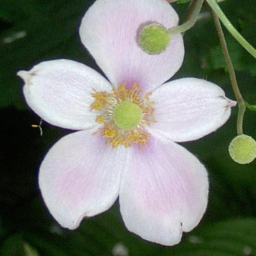
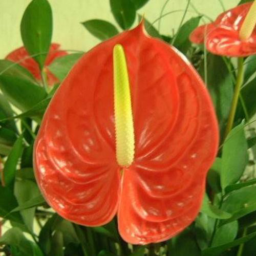
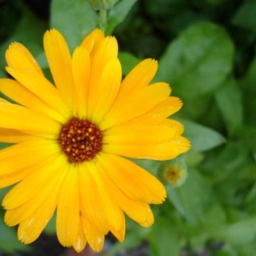
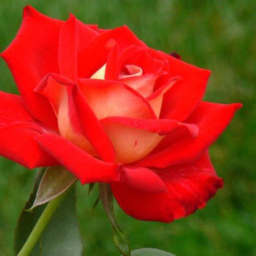
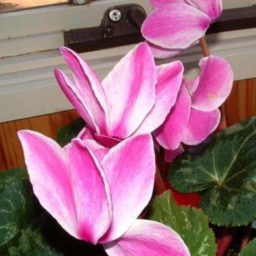
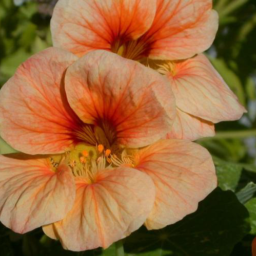
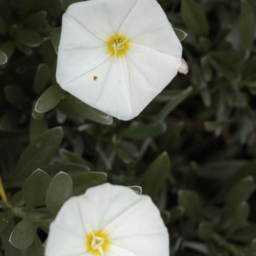
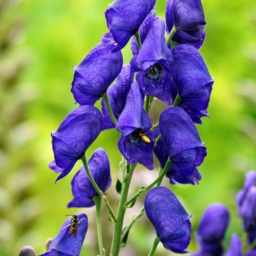
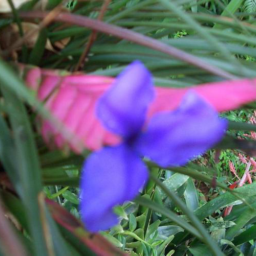
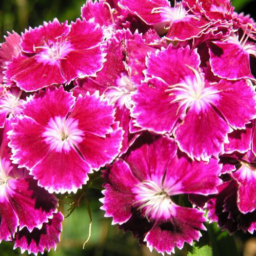
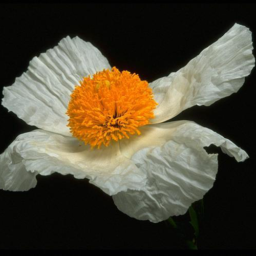
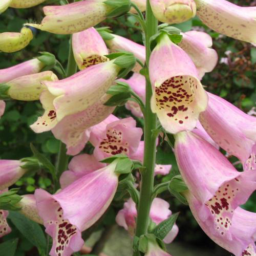
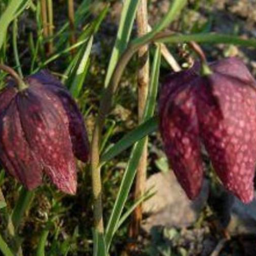
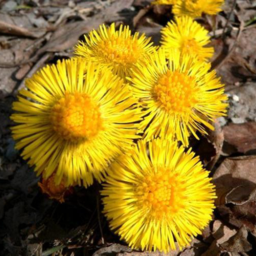
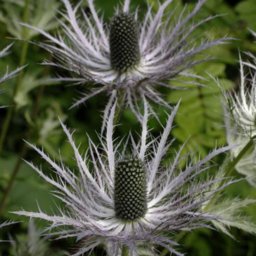
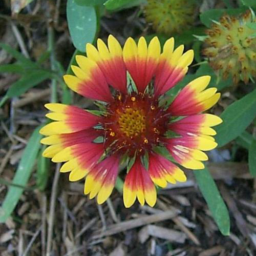

In [94]:
// sampleTable generates and outputs one html table of samples, sampling rows x cols from the images/labels provided.
func sampleTable(title string, ds train.Dataset, rows, cols int) {
    htmlRows := make([]string, 0, rows)
    for row := 0; row < rows; row++ {
        cells := make([]string, 0, cols)
        for col := 0; col < cols; col++ {
            cells = append(cells, sampleOneImage(ds))
        }
        htmlRows = append(htmlRows, fmt.Sprintf("<tr>\n\t<td>%s</td>\n</tr>", strings.Join(cells, "</td>\n\t<td>")))
    }
    htmlTable := fmt.Sprintf("<h4>%s</h4><table>%s</table>\n", title, strings.Join(htmlRows, ""))
    gonbui.DisplayHTML(htmlTable)
}

// sampleOneImage one image from tensor and returns an HTML rendered image with label
func sampleOneImage(ds train.Dataset) string {
    _, inputs, labels := must.M3(ds.Yield())
    imgTensor := inputs[0]
    img := timage.ToImage().Single(imgTensor)
    exampleNum := inputs[1].Value().(int64)
    label := labels[0].Value().(int32)
    labelStr := flowers.Names[label]
    
    imgSrc := must.M1(gonbui.EmbedImageAsPNGSrc(img))
    width, height := imgTensor.Shape().Dimensions[0], imgTensor.Shape().Dimensions[1]
    return fmt.Sprintf(`<figure style="padding:4px;text-align: center;"><img width="%d" height="%d" src="%s"><figcaption style="text-align: center;">Example %d:<br/><span>%s (%d)</span><br/>(%dx%d pixels)</figcaption></figure>`, 
                       width, height, imgSrc, exampleNum, labelStr, label, img.Bounds().Dx(), img.Bounds().Dy())
}

%% --set="image_size=256"
cfg := NewConfig()
must.M(flowers.DownloadAndParse(cfg.DataDir))
ds := flowers.NewDataset(dtypes.U8, cfg.ImageSize)
ds.Shuffle()
sampleTable("Oxford 102 Flowers Sample", ds, 4, 4)


Total number of examples: #train=6487, #validation=1702
trainDS (in-memory) using 304.2 MiB of memory.
validationDS (in-memory) using 79.8 MiB of memory.


Oxford 102 Flowers Sample -- In-Memory Dataset 
 Example 4685: buttercup (47) (128x128 pixels) 
 Example 6636: canterbury bells (2) (128x128 pixels) 
 Example 6598: grape hyacinth (24) (128x128 pixels) 
 Example 5096: hard-leaved pocket orchid (1) (128x128 pixels)
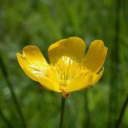
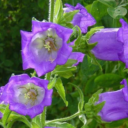
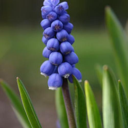
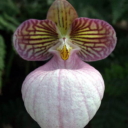

In [95]:
// Remove cached file to force regeneratrion.
// !rm -f "${HOME}/work/oxfordflowers102/"*_cached_images_*

%% --set="image_size=128"
cfg := NewConfig()
trainDS, validationDS := cfg.CreateInMemoryDatasets()

fmt.Println()
fmt.Printf("Total number of examples: #train=%d, #validation=%d\n", trainDS.NumExamples(), validationDS.NumExamples())
fmt.Printf("trainDS (in-memory) using %s of memory.\n", data.ByteCountIEC(trainDS.Memory()))
fmt.Printf("validationDS (in-memory) using %s of memory.\n", data.ByteCountIEC(validationDS.Memory()))

// Output a random sample.
trainDS.Shuffle()
sampleTable("Oxford 102 Flowers Sample -- In-Memory Dataset", trainDS, 1, 4)

### Training

Because it can take hours, we recommend training from the command-line.

For this demos we trained two models, one for 64x64 images and another for 128x128 using [github.com/gomlx/gomlx/examples/FlowMatching/demo](https://github.com/gomlx/gomlx/tree/main/examples/FlowMatching/demo). Where how we ran them (from the `demo` directory):

1. **fm_64x64**: `go run . --checkpoint fm_64x64`
2. **fm_128x128**: `go run . --checkpoint=fm_128x128 --set='image_size=128;diffusion_channels_list=32,64,96,128,160;diffusion_num_residual_blocks=6;learning_rate=1e-2;diffusion_loss=huber'

Below we train from the notebook, for just 100 steps. We use this during development to test things are working.


In [48]:
!rm -rf ~/work/oxfordflowers102/fm_base

In [86]:
%% --checkpoint fm_base --set=train_steps=100
cfg := NewConfig()
fm.TrainModel(cfg, *flagCheckpoint, *flagEval, *flagVerbosity)

Backend "xla":	xla:cuda - PJRT "cuda" plugin (/usr/local/lib/gomlx/pjrt/pjrt_c_api_cuda_plugin.so) v0.55
	Checkpoint: "/home/janpf/work/oxfordflowers102/fm_base"
	train_steps=100


(...collecting metrics, minimum 3 required to start plotting...)

Training (100 steps):  100% [========================================] (11 steps/s) [step=99] [loss+=0.631] [~loss+=0.836] [~loss=0.836]                   
	[Step 100] median train step: 93256 microseconds

Results on train:
	Mean Loss+Regularization (#loss+): 0.653
	Mean Loss (#loss): 0.653
Results on validation:
	Mean Loss+Regularization (#loss+): 0.664
	Mean Loss (#loss): 0.664


### Training Progression

By default the training library in `fm.TrainModel` will pre-generate a fixed set of random noise at the start of the training, and every now and then tranform that noise into a sampled image. This we way we can see how the generative model is progressing.

The function `fm.PlotModelEvolution` can display a subset of those sampled images, along with the `global_step` of the model at the time the image was generated. Set `animation=true` to display it as an animation (instead of a list).

	Checkpoint: "/home/janpf/work/oxfordflowers102/fm_64x64"


**Generated samples in `/home/janpf/work/oxfordflowers102/fm_64x64`:**

- global_step 200:



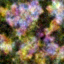
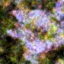
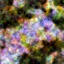
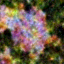
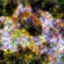
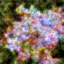
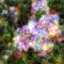
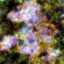

- global_step 440:



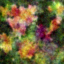
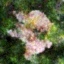
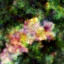
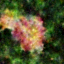
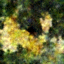
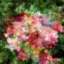
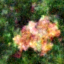
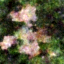

- global_step 728:



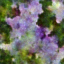
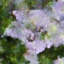
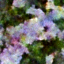
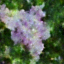
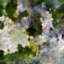
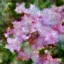
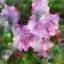
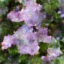

- global_step 1074:



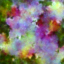
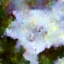
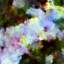
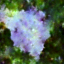
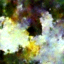
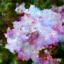
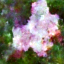
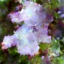

- global_step 1489:



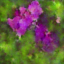
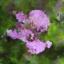
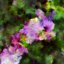
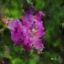
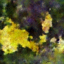
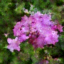
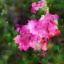
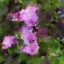

- global_step 1987:



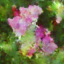
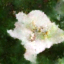
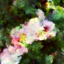
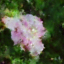
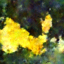
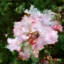
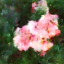
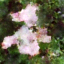

- global_step 2585:



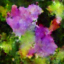
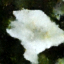
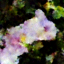
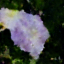
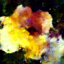
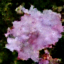
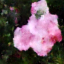
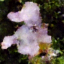

- global_step 3303:



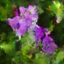
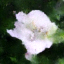
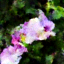
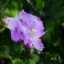
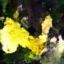
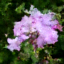
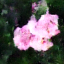
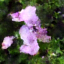

- global_step 4165:



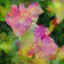
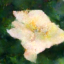
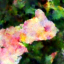
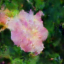
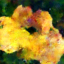
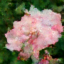
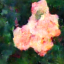
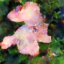

- global_step 5199:



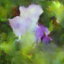
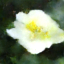
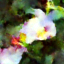
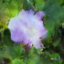
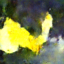
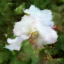
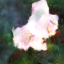
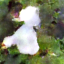

- global_step 6440:



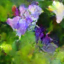
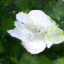
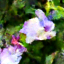
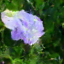
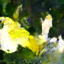
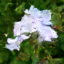
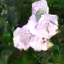
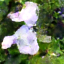

- global_step 7929:



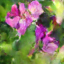
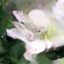
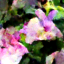
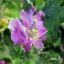
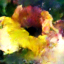
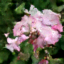
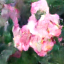
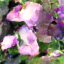

- global_step 9716:



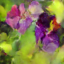
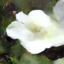
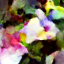
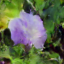
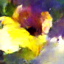
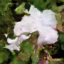
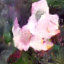
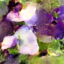

- global_step 11860:



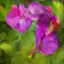
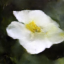
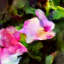
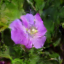
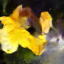
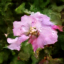
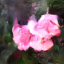
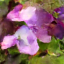

- global_step 14433:



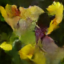
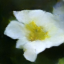
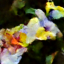
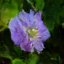
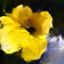
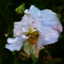
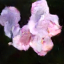
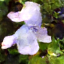

- global_step 17521:



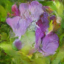
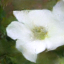
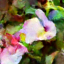
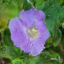
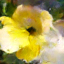
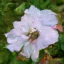
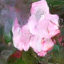
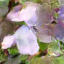

- global_step 21227:



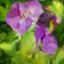
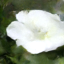
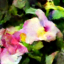
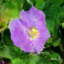
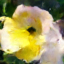
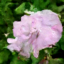
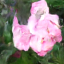
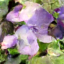

- global_step 25674:



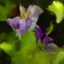
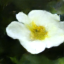
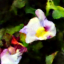
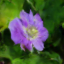
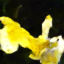
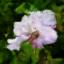
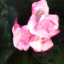
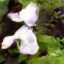

- global_step 31010:



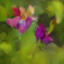
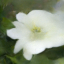
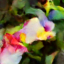
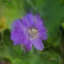
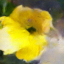
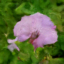
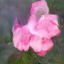
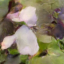

- global_step 37413:



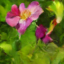
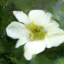
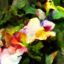
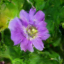
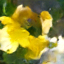
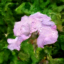
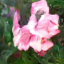
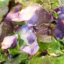

- global_step 45097:



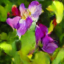
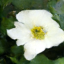
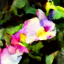
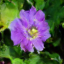
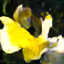
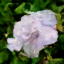
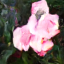
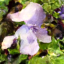

- global_step 54318:



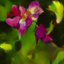
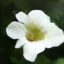
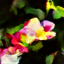
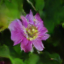
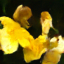
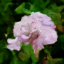
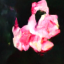
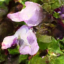

- global_step 65383:



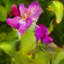
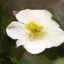
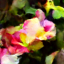
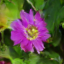
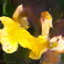
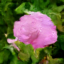
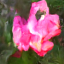
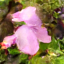

- global_step 78661:



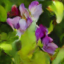
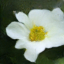
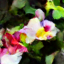
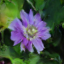
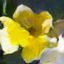
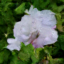
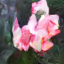
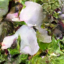

- global_step 94595:



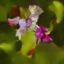
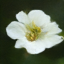
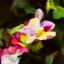
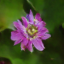
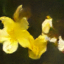
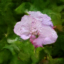
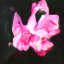
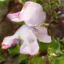

- global_step 113716:



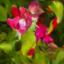
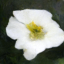
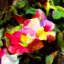
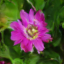
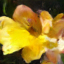
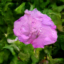
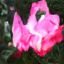
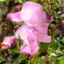

- global_step 136661:



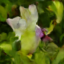
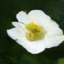
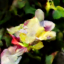
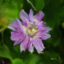
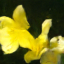
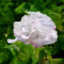
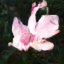
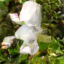

- global_step 164195:



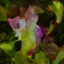
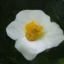
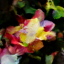
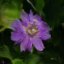
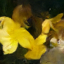
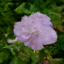
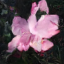
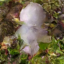

- global_step 197236:



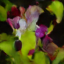
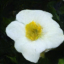
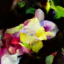
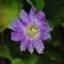
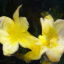
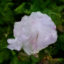
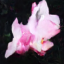
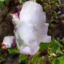

- global_step 236885:



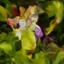
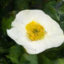
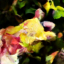
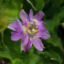
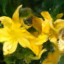
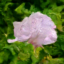
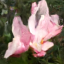
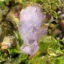

- global_step 284464:



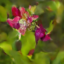
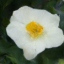
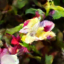
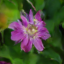
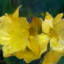
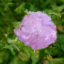
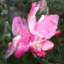
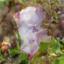

- global_step 300000:



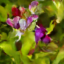
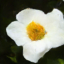
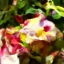
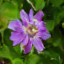
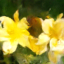
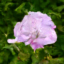
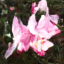
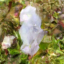

In [113]:
%% --checkpoint fm_64x64
cfg := NewConfig()
cfg.AttachCheckpoint(*flagCheckpoint)
fm.PlotModelEvolution(cfg, 8, /*animate=*/ false)

### Sample Flowers

This is how we sample flowers from the trainined model. `fm.DisplayImagesAcrossTime` takes the number of images to generate, how many steps to generate the image -- the more the better, but it is slower -- and if to display some intermediary images as the final image is being generated.

	Checkpoint: "/home/janpf/work/oxfordflowers102/fm_64x64"
DisplayImagesAcrossDiffusionSteps(16 images, 20 steps): noise.shape=(Float32)[16 64 64 3]
	Model #params:	4400646
	 Model memory:	16.8 MiB


0.00% Denoised


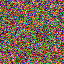
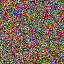
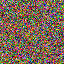
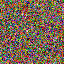
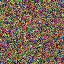
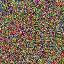
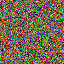
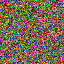
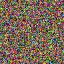
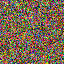
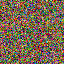
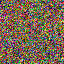
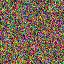
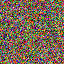
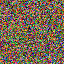
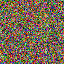

21.05% Denoised


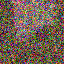
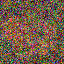
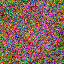
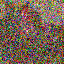
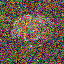
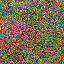
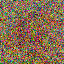
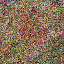
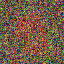
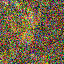
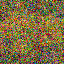
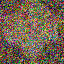
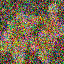
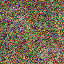
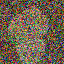
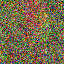

42.11% Denoised


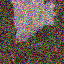
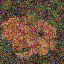
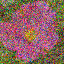
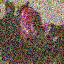
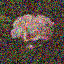
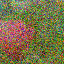
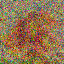
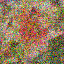
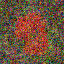
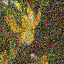
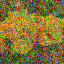
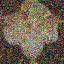
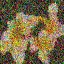
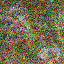
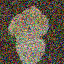
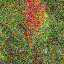

63.16% Denoised


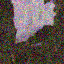
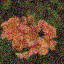
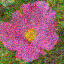
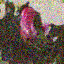
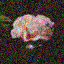
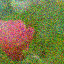
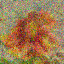
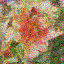
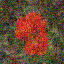
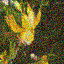
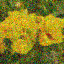
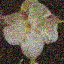
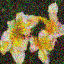
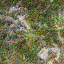
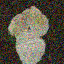
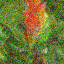

84.21% Denoised


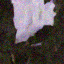
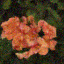
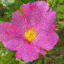
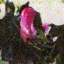
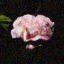
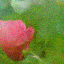
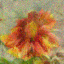
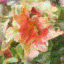
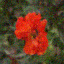
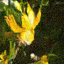
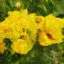
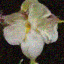
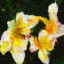
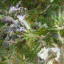
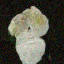
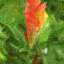

100.00% Denoised


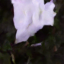
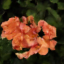
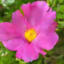
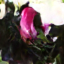
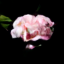
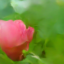
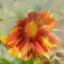
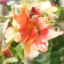
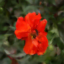
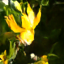
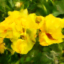
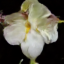
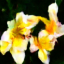
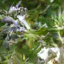
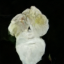
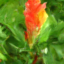

In [114]:
%% --checkpoint fm_64x64
cfg := NewConfig()
cfg.AttachCheckpoint(*flagCheckpoint)
fm.DisplayImagesAcrossTime(cfg, /*numImages*/ 16, /* numSteps */ 20, /*dispalyeEveryNSteps*/ 4)

	Checkpoint: "/home/janpf/work/oxfordflowers102/fm_128x128"
DisplayImagesAcrossDiffusionSteps(8 images, 20 steps): noise.shape=(Float32)[8 128 128 3]
	Model #params:	11963750
	 Model memory:	45.6 MiB


100.00% Denoised


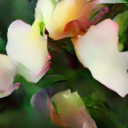
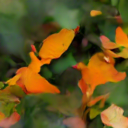
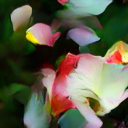
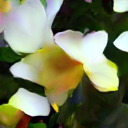
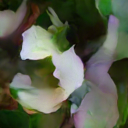
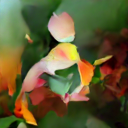
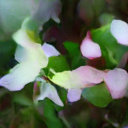
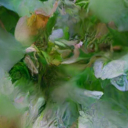

In [112]:
%% --checkpoint fm_128x128
cfg := NewConfig()
cfg.AttachCheckpoint(*flagCheckpoint)
fm.DisplayImagesAcrossTime(cfg, 8, 20, 0)